# Import

In [1]:
%pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [3]:
# Standard Libraries
import numpy as np
import pandas as pd
import requests
import warnings
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# Web Scraping
from bs4 import BeautifulSoup

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Boosting Algorithms
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from data_processing import *

# Suppress warnings
warnings.filterwarnings('ignore')

# GoogleDrive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Parsing Data

http://magnitogorsk-citystar.ru/realty/prodazha-kvartir

In [4]:
# Функция для получения содержимого веб-страницы
def get_page_soup(url: str) -> BeautifulSoup:
    r = requests.get(url)
    if not r.ok:
        return None
    return BeautifulSoup(r.text, "html.parser")

In [5]:
%%script false --no-raise-error

# Функция для извлечения данных из страницы с объявлениями
def extract_ad(soup: BeautifulSoup) -> pd.DataFrame:
    # Извлечение ID объявлений
    all_id = soup.findAll('span', class_='ibf')

    # Извлечение информации о количестве комнат и типе планировки
    all_flat_type = soup.findAll('td', class_='flat-type')

    # Извлечение адреса
    address = [x.get_text(separator=",").split(',') for x in soup.findAll('td', class_='address')]

    # Извлечение информации о этаже
    floor = soup.findAll('td', class_='floor')

    # Извлечение площади квартиры
    square = [x.text[:-3].split('/') for x in soup.findAll('td', class_='square')]

    # Извлечение цены квартиры
    price = soup.findAll('td', class_='price')

    # Формирование итогового датафрейма
    data = {
        'id': [int(x['id'][7:]) for x in all_id],
        'num_rooms': [int(x.text[0]) if x.text and x.text[0].isnumeric() else -1 for x in all_flat_type],
        'flat': [x.text[2:] if len(x.text) > 2 else None for x in all_flat_type],
        'district': [x[0].lower() if any(district in x[0].lower() for district in ['орджоникидзевский', 'ленинский', 'правобережный']) else None for x in address],
        'house': [','.join(x[1:]).strip() if any(district in x[0].lower() for district in ['орджоникидзевский', 'ленинский', 'правобережный']) else ','.join(x).strip() for x in address],
        'floor_num': [int(x.text.split('/')[0]) for x in floor],
        'floors_num': [int(x.text.split('/')[1]) for x in floor],
        'square_total': [float(x[0].replace(',', '.')) for x in square],
        'square_living': [float(x[1].replace(',', '.')) for x in square],
        'square_kitchen': [float(x[2].replace(',', '.')) for x in square],
        'price': [int(x.text.replace('\xa0', '')[:-2]) if x.text else 0 for x in price]
    }

    return pd.DataFrame(data)

# Сбор данных с нескольких страниц
dfs = []
for _ in tqdm(range(20)):
    soup = get_page_soup(f"http://magnitogorsk-citystar.ru/realty/prodazha-kvartir/?p={_ + 1}")
    if not soup:
        break
    df = extract_ad(soup)
    if df is None:
        break
    dfs.append(df)

# Объединение данных из разных страниц в один датафрейм
df = pd.concat(dfs).reset_index(drop=True)

# Преобразование типов данных для определенных столбцов
for col_name in ('id', 'num_rooms', 'floors_num', 'floor_num', 'price'):
    df[col_name] = df[col_name].astype('int')

In [6]:
# df.to_csv('/drive/My Drive/datasets/CityStarExport-04.10.2023.csv', index=False)

# Process Data

In [7]:
df = pd.read_csv('/drive/My Drive/datasets/CityStarExport-04.10.2023.csv')

In [8]:
process_data(df, visualize=False)

Missing values percentage:

id                 0.000000
num_rooms          0.000000
flat              74.215247
district          42.600897
house              1.121076
floor_num          0.000000
floors_num         0.000000
square_total       0.000000
square_living      0.000000
square_kitchen     0.000000
price              0.000000
dtype: float64



In [9]:
# Функция для определения категории этажа на основе признаков 'floor_num' и 'floors_num'
def floor_cat(row):
    if row['floor_num'] == row['floors_num']:
        return 'верхний'
    elif row['floor_num'] == 1:
        return 'нижний'
    else:
        return 'промежуточный'

In [10]:
# Применяем функцию к датафрейму
df['floor_cat'] = df.apply(floor_cat, axis=1)

In [11]:
# Унифицируем значения в столбце 'district'
df['district'] = df['district'].replace({
    'орджоникидзевский (левый берег)': 'орджоникидзевский',
    'орджоникидзевский (правый берег)': 'орджоникидзевский',
    'ленинский (левый берег)': 'ленинский'
})

In [12]:
# Удаляем ненужные столбцы
df.drop(['id', 'flat', 'house', 'floor_num'], axis=1, inplace=True)

In [13]:

# Создаем списки категориальных и числовых признаков
cat_features = df.select_dtypes(include='object').columns
num_features = df.select_dtypes(exclude='object').columns

In [14]:

# Проверяем количество пропущенных значений в столбце 'num_rooms'
missing_num_rooms = df[df['num_rooms'] == -1]['num_rooms'].count()
print(f"Missing 'num_rooms' values: {missing_num_rooms}")

Missing 'num_rooms' values: 14


In [15]:
# Удаляем строки с пропущенными значениями
df = df[df['num_rooms'] >= 1].dropna(subset=['district'])

# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 0 to 445
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_rooms       255 non-null    int64  
 1   district        255 non-null    object 
 2   floors_num      255 non-null    int64  
 3   square_total    255 non-null    float64
 4   square_living   255 non-null    float64
 5   square_kitchen  255 non-null    float64
 6   price           255 non-null    int64  
 7   floor_cat       255 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 17.9+ KB


In [16]:
process_data(df, visualize=False)

Missing values percentage:

num_rooms         0.0
district          0.0
floors_num        0.0
square_total      0.0
square_living     0.0
square_kitchen    0.0
price             0.0
floor_cat         0.0
dtype: float64



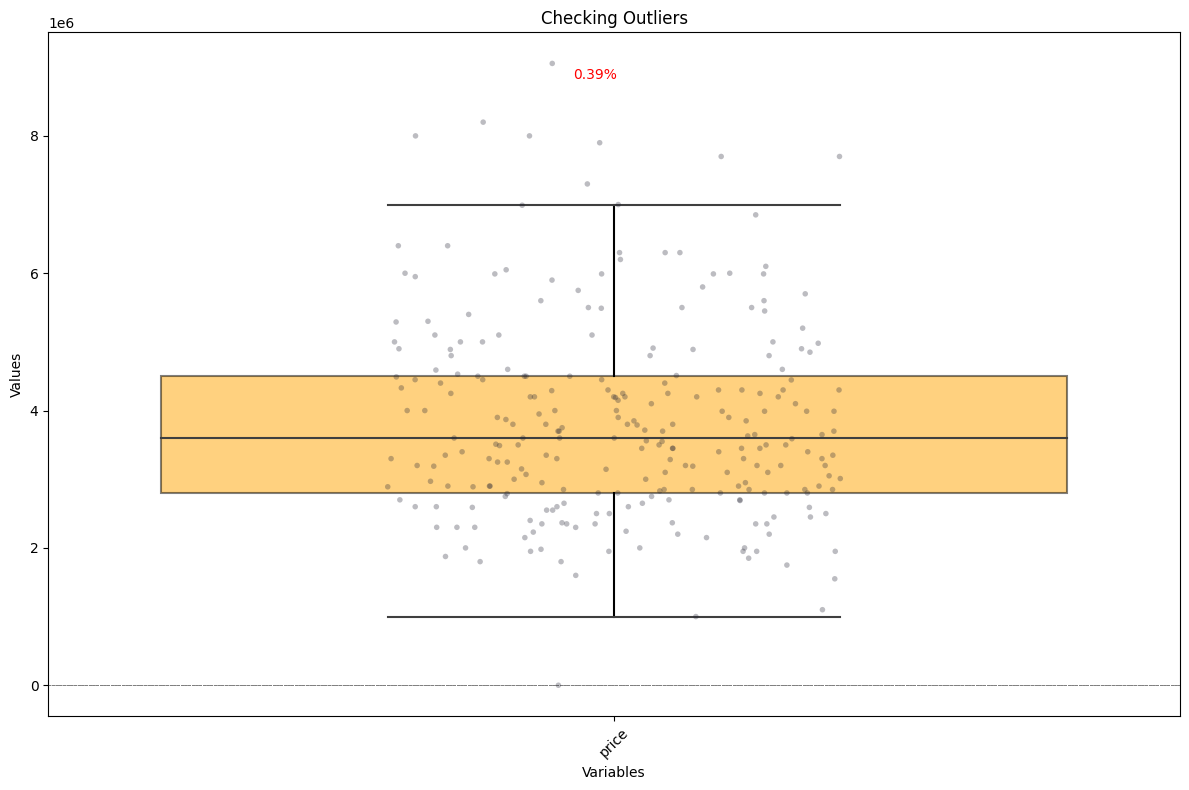

price - Outliers: 0.39%


In [17]:
plot_outliers(df[['price']])

In [18]:
plot_outliers(df, handle_outliers="replace");

No columns with outliers to visualize.


Вывод. Среди значений числовых признаков явных аномалий нет.

# Transfrom Data

In [19]:
# Отделим целевой признак от остальных.
X = df.drop(['price'], axis=1)
y = df['price']

# Отделим 20% данных для тестовой выборки.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345)

display(X_train.shape, X_test.shape)

(204, 7)

(51, 7)

In [20]:
# Исключим из списка числовых обучающих признаков целевой
num_features = num_features[:-1]

# Создаем экземпляр класса DataPreprocessor
data_preprocessor = DataPreprocessor()

# Применяем метод fit_transform к обучающим данным и метод transform к тестовым данным
X_train_transform = data_preprocessor.fit_transform(X_train)
X_test_transform = data_preprocessor.transform(X_test)

In [21]:
# Сохраняем трансформер в файл
# joblib.dump(data_preprocessor.preprocessor, '/drive/My Drive/preprocessor.pkl')

# Modeling

In [22]:
# Создадим нулевой датафрейм, куда будут записаваться данные о качестве прогнозирования
cols_results = ['RMSE', 'r2_score']
index_results = ['baseline', 'linear_regression', 'catboost']
df_results = pd.DataFrame(data=0 , columns=cols_results, index=index_results)

## Константая (baseline) модель

In [61]:
# Обучим и оценим константную модель
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_transform, y_train)
y_pred_dummy = dummy_reg.predict(X_test_transform)

rmse_dummy = mse(y_test, y_pred_dummy, squared=False)
r2_dummy = r2_score(y_test, y_pred_dummy)

df_results.loc['baseline', 'RMSE'] = rmse_dummy
df_results.loc['baseline', 'r2_score'] = r2_dummy

print(f"Оценка RMSE константной модели: {rmse_dummy}")
print(f"Оценка коэффициента детерминации R2 константной модели: {r2_dummy}")

Оценка RMSE константной модели: 1594376.6868890843
Оценка коэффициента детерминации R2 константной модели: -0.0009434150014091536


## LinearRegression

In [62]:
# Обучим и оценим модель линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(X_train_transform, y_train)
y_pred_lin = lin_reg.predict(X_test_transform)

rmse_lin = mse(y_test, y_pred_lin, squared=False)
r2_lin = r2_score(y_test, y_pred_lin)

df_results.loc['linear_regression', 'RMSE'] = rmse_lin
df_results.loc['linear_regression', 'r2_score'] = r2_lin

print(f"Оценка RMSE модели линейной регрессии: {rmse_lin}")
print(f"Оценка коэффициента детерминации R2 модели линейной регрессии: {r2_lin}")

Оценка RMSE модели линейной регрессии: 696993.996686651
Оценка коэффициента детерминации R2 модели линейной регрессии: 0.8087128789812558


In [63]:
# Экспорт модели
# joblib.dump(lin_reg, '/drive/My Drive/lin_reg.pkl')

## CatBoost

In [64]:
# Указываем гиперпараметры алгоритма градиентного бустинга
params = {
    'iterations': 500,
    'eval_metric': 'RMSE',
    'random_state': 12345,
    'verbose': False
}

In [65]:
# Варьируемые гиперпараметры
params_search = {'depth': [4, 6],
                 'learning_rate': [0.01, 0.03]}

In [66]:
# Инициализируем модель градиентного бустинга
catboost = CatBoostRegressor(**params)

# Указываем параметры алгоритма подбора гиперпараметров
grid = GridSearchCV(estimator=catboost,
                    scoring='neg_mean_squared_error',
                    cv=3,
                    param_grid=params_search)

In [67]:
# 1. Обучение модели градиентного бустинга с использованием кросс-валидации
grid.fit(X_train_transform, y_train)
y_pred_catboost = grid.predict(X_test_transform)

# 2. Определение лучших гиперпараметров модели
best_params = grid.best_params_
print(f"Лучшие гиперпараметры для модели градиентного бустинга: {best_params}")

Лучшие гиперпараметры для модели градиентного бустинга: {'depth': 6, 'learning_rate': 0.03}


In [68]:
# Запись результатов в таблицу
rmse_score = round(abs(grid.best_score_)**0.5)
r2_catboost = r2_score(y_test, y_pred_catboost)

df_results.loc['catboost', 'RMSE'] = rmse_score
df_results.loc['catboost', 'r2_score'] = r2_catboost

print(f"RMSE лучшей модели градиентного бустинга на кросс-валидации: {rmse_score}")
print(f"Оценка коэффициента детерминации R2 модели градиентного бустинга: {r2_catboost}")

RMSE лучшей модели градиентного бустинга на кросс-валидации: 780433
Оценка коэффициента детерминации R2 модели градиентного бустинга: 0.7736771975681742


In [69]:
# Экспорт модели в JSON
# grid.best_estimator_.save_model("/drive/My Drive/catboost_model.json", format="json")

# Анализ моделей

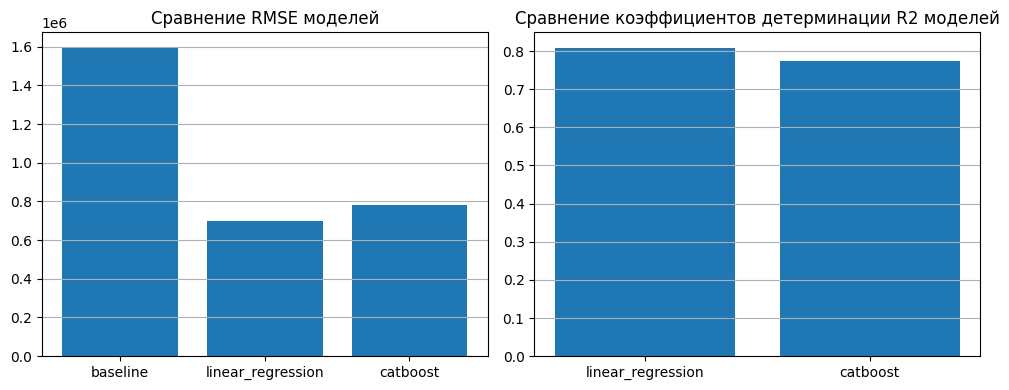

In [75]:
# 5. Визуализация результатов

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(df_results.index, df_results['RMSE'])
ax[0].set_title('Сравнение RMSE моделей')
ax[0].grid(axis='y')

ax[1].bar(df_results.index[1:], df_results['r2_score'][1:])
ax[1].set_title('Сравнение коэффициентов детерминации R2 моделей')
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

Вывод. Лучшие результаты показала модель линейной регрессии.

# Оценка качества лучшей модели на тестовой выборке

In [71]:
# Прогнозирование на тестовой выборке и вычисление RMSE
# predictions = grid.best_estimator_.predict(X_test_transform)
predictions = lin_reg.predict(X_test_transform)
test_rmse = mse(y_test, predictions, squared=False).round(0)
print(f"RMSE лучшей модели на тестовой выборке: {test_rmse}")

RMSE лучшей модели на тестовой выборке: 696994.0
